# Exploratory and Statistical Analysis on the Data

We will perform exploratory and statistical analysis on our data, to have preliminary answers to our research questions. We will observe and investigate the influence of the following factors on the ending score: 

1) The genre(s) of the movie
2) The release date and influence of historical events
3) The key personnel of the movie (actors, directors...)
4) The movie' "success" (financial performance and popularity)
5) The region of production and the language of the movie
6) The budget and production scale of the movie
7) The movie's duration
8) The fact that the movie is part of collection of movies (e.g. part of a trilogy)


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import ast
import scipy.stats as stats


from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


In [3]:
# path
DATA_FOLDER = 'src/data/'
MOVIE_DATASET = DATA_FOLDER + 'movies_dataset_final.tsv'

# Dataset loading
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

## 1. Movie genres

How does the genre of a movie influence the type of ending it has (happy, tragic)? Certain genres may have a higher likelihood of happy or tragic endings.

### 1.1 Cleaning and Filtering Movie Genres

What kind of genres do we have in this dataset ? And how many movies for each genre ?

In [64]:
#Drop rows with no score
movies['Movie genres'] = movies['Movie genres'].str.lower()
genre_counts = movies['Movie genres'].str.split(', ').explode().value_counts().reset_index()
genre_counts.columns = ['Genre', 'Number of movies']
genre_counts = genre_counts.sort_values(by='Number of movies', ascending=False)
print("Number of genres:", len(genre_counts))

Number of genres: 346


We observe that we have 346 different movie genres. We will keep only the most common ones (some genres have only one or a few films), and choose the ones that have .

In [65]:
genre_counts = genre_counts[genre_counts['Number of movies'] > 500]
print("Number of genres of our interest for our analysis: ", len(genre_counts))

Number of genres of our interest for our analysis:  36


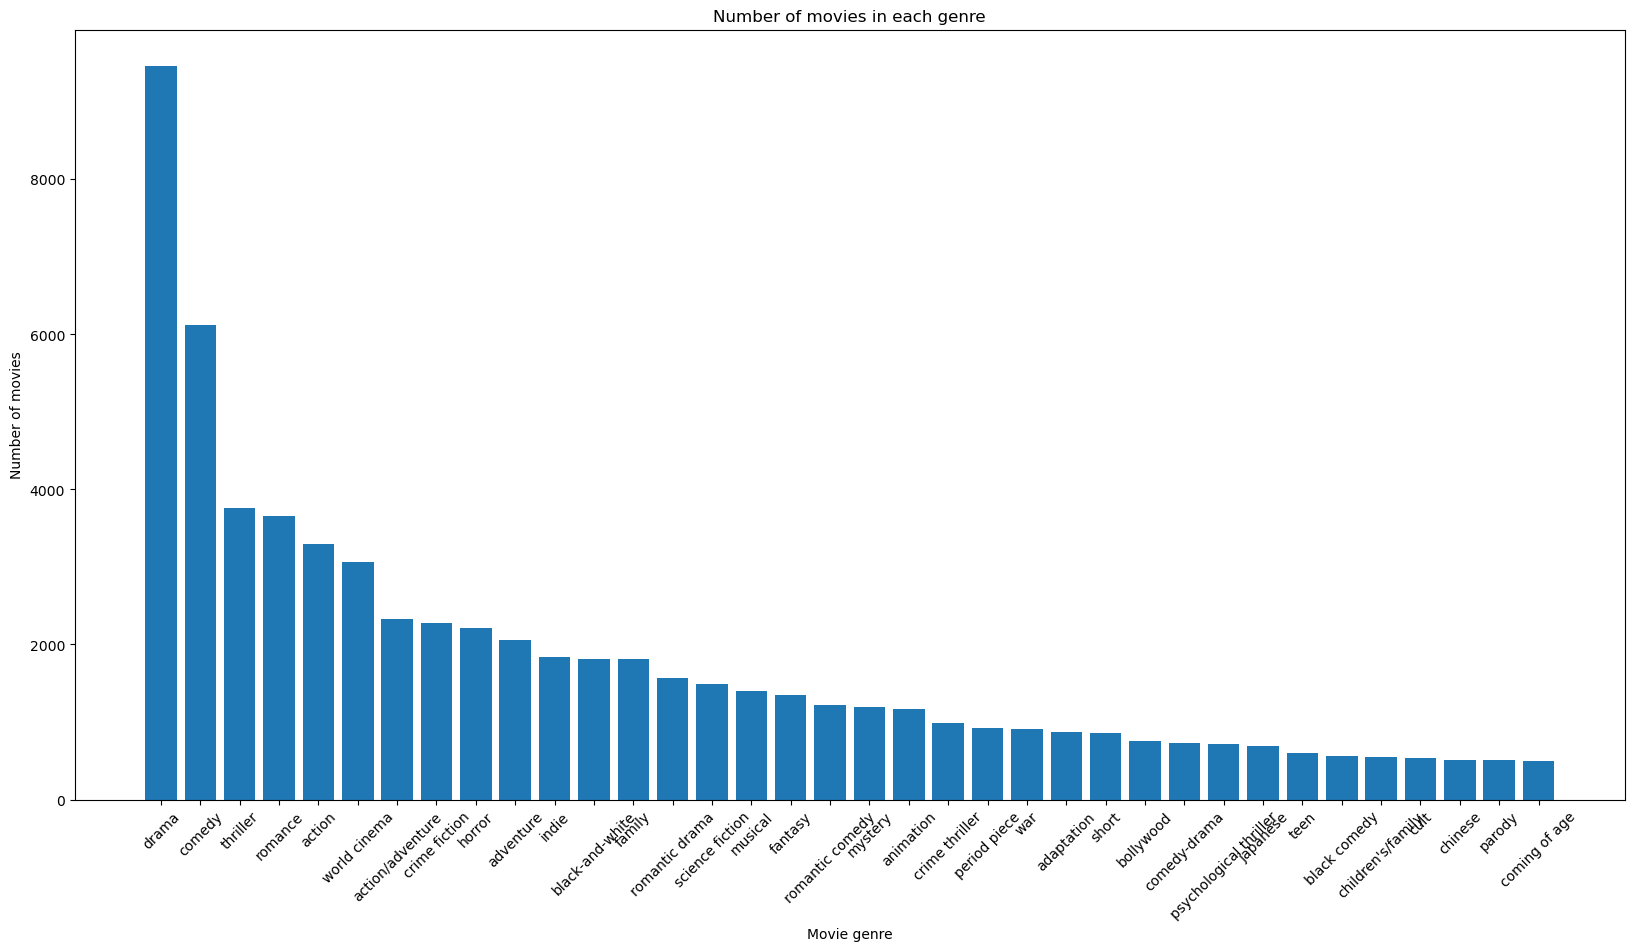

In [66]:
# Plot the number of movies in each genre 
plt.figure(figsize=(20, 10))
plt.bar(genre_counts['Genre'], genre_counts['Number of movies'])
plt.xticks(rotation=45)
plt.xlabel('Movie genre')
plt.ylabel('Number of movies')
plt.title('Number of movies in each genre')
plt.show()


Now that we have cleaned, regrouped and selected the movie genres, we will create a new dataset with only the movies that have any of these genres of our interest.

In [67]:
# New dataframe 
movies_genres = movies.copy()
movies_genres = movies_genres.dropna(subset=['Movie genres'])
movies_genres = movies_genres.dropna(subset=['Score'])
movies_genres['Movie genres'] = movies_genres['Movie genres'].str.split(', ')
movies_genres = movies_genres.explode('Movie genres')
movies_genres = movies_genres.reset_index(drop=True)
movies_genres['Movie genres'] = movies_genres['Movie genres'].str.lower()

# Remove the rows of the movies_genres dataframe which genre is not in the genre_counts dataframe
movies_genres = movies_genres[movies_genres['Movie genres'].isin(genre_counts['Genre'])]
movies_genres = movies_genres.reset_index(drop=True)

Now that we have clean data with only the most relevant genres for each film, we can anlayze it.

### 1.2 Exploratory analysis of the relationship between ending score and the movie genres

First we can observe the mean score of ending for each movie genre.

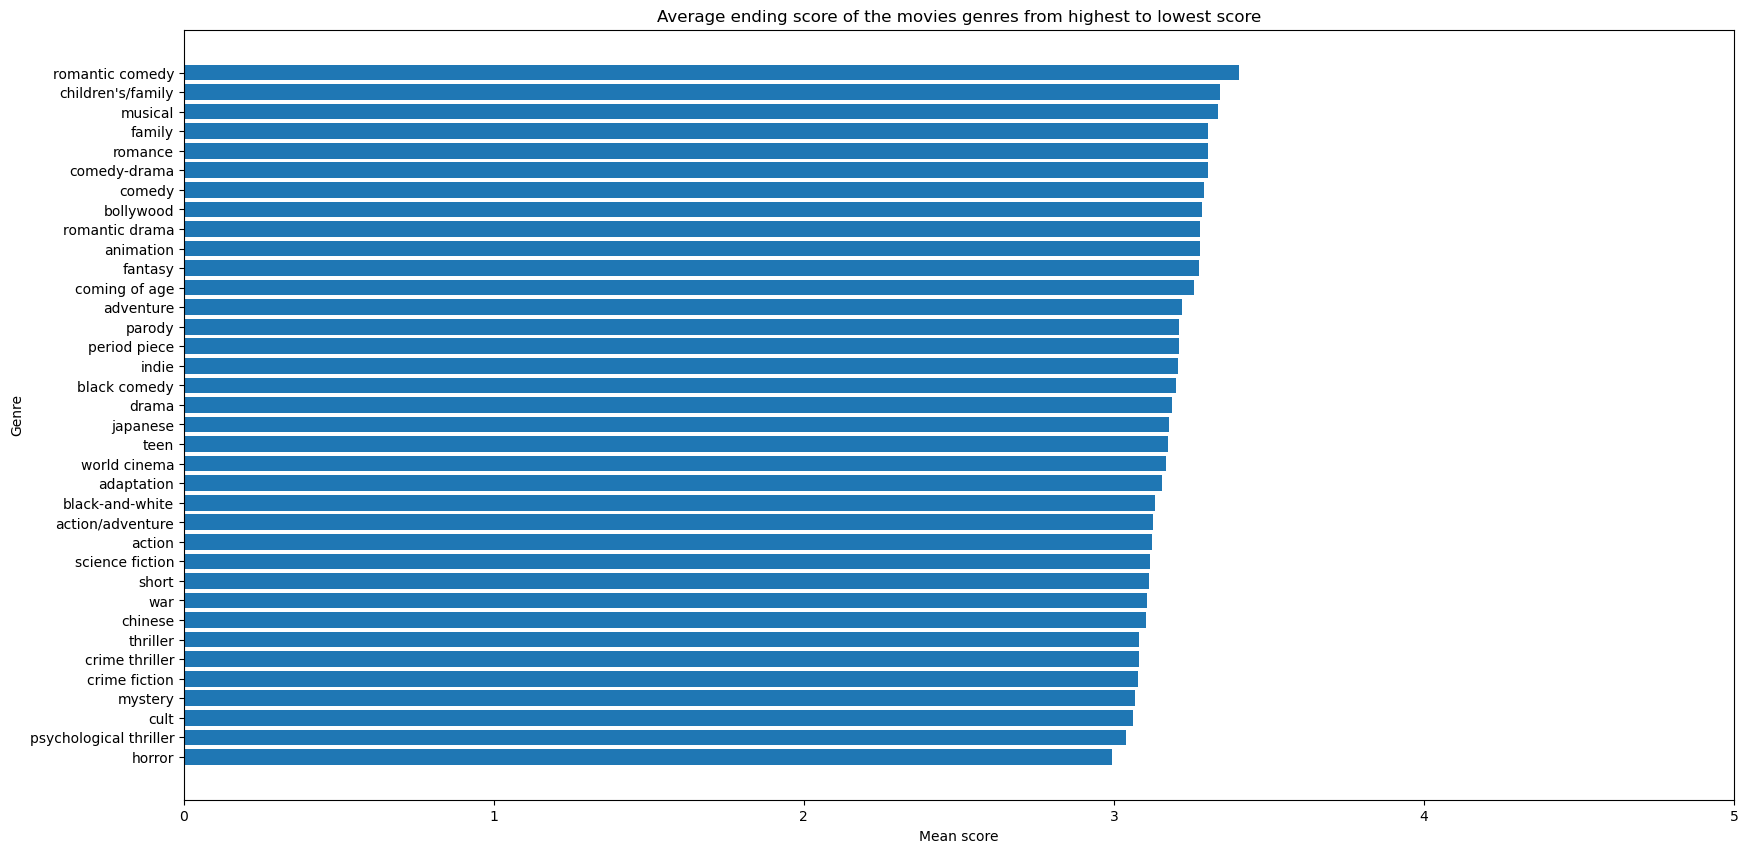

In [68]:
# Mean ending score for each genre
genre_scores = movies_genres.groupby('Movie genres').agg({'Score': 'mean', 'Movie genres': 'count'})
genre_scores.columns = ['Mean score', 'Number of movies']
genre_scores = genre_scores.reset_index()
genre_scores = genre_scores.sort_values(by='Mean score', ascending=True)
genre_scores = genre_scores.reset_index(drop=True)

# Plot of the average score of the movie genres from best to worst ending score
plt.figure(figsize=(20, 10))
plt.barh(genre_scores['Movie genres'], genre_scores['Mean score'])
plt.xlim(0, 5)
plt.xlabel('Mean score')
plt.ylabel('Genre')
plt.title('Average ending score of the movies genres from highest to lowest score')
plt.show()

We observe that the average ending score does vary from one genre to the other but the difference is not that important. 
Let's have a look at what genres have the five highest and five lowest ending scores.
We can then have a look at the distribution of the movies per score for the highest ending score genre and the lowest ending score genre.

In [69]:
#Highest mean score genres
genre_high_scores = genre_scores.sort_values(by='Mean score', ascending=False)

print("The 5 genres with the highest mean score are:")
print(genre_high_scores.head(5))

The 5 genres with the highest mean score are:
         Movie genres  Mean score  Number of movies
35    romantic comedy    3.405094              1217
34  children's/family    3.342391               552
33            musical    3.337151              1397
32             family    3.303265              1807
31            romance    3.302931              3651


In [70]:
#Lowest mean score genres
print("The 5 genres with the lowest mean score are:")
print(genre_high_scores.tail(5))

The 5 genres with the lowest mean score are:
             Movie genres  Mean score  Number of movies
4           crime fiction    3.078647              2276
3                 mystery    3.068792              1192
2                    cult    3.060150               532
1  psychological thriller    3.037921               712
0                  horror    2.993207              2208


In [71]:
#Distibution of the number of movies per ending score for the genre with the highest average score and the score withe the lowest average score
worst_genre = genre_high_scores.tail(1)['Movie genres'].values[0]
best_genre = genre_high_scores.head(1)['Movie genres'].values[0]

worst_genre_scores = movies_genres[movies_genres['Movie genres'] == worst_genre]['Score']
best_genre_scores = movies_genres[movies_genres['Movie genres'] == best_genre]['Score']

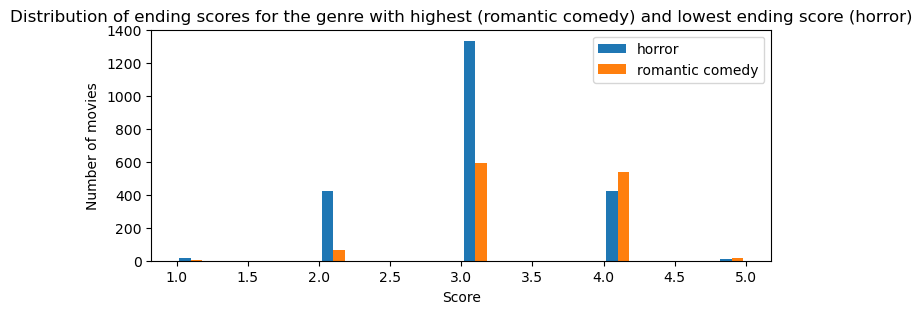

In [72]:
#PLot a histogram where the x axis is the score from 1 to 5 and the y axis is the number of movies that have this score, but for each score I want two bars one for the worst genre and one for the best genre
plt.figure(figsize=(8, 3))
plt.hist([worst_genre_scores, best_genre_scores], bins=20, range=(1, 5), label=[worst_genre, best_genre])
plt.xlabel('Score')
plt.ylabel('Number of movies')
plt.title('Distribution of ending scores for the genre with highest (romantic comedy) and lowest ending score (horror)')
plt.legend()
plt.show()

We observe that these 2 genres have significant different distributions.

To get more insight on this, we will perform some statistical tests to further explore if there is a relationship between the genre of a movie and its ending.

### 1.3 Statistical analysis of the relationship between ending score and the movie genres

We can perform can perform a Chi-square test, which is used to determine whether there is a significant association between two categorical variables. Using it, we can determine if the movie genres and the ending scores are related or not, since these two variables are categorical. 

Null Hypothesis: Movie genres and ending scores are independent.

Alternative Hypothesis: Movie genres and ending scores are not independent.

Chi-Square Statistic: 1469.3927914378085
P-Value: 3.135541267890827e-220
Degrees of Freedom: 140


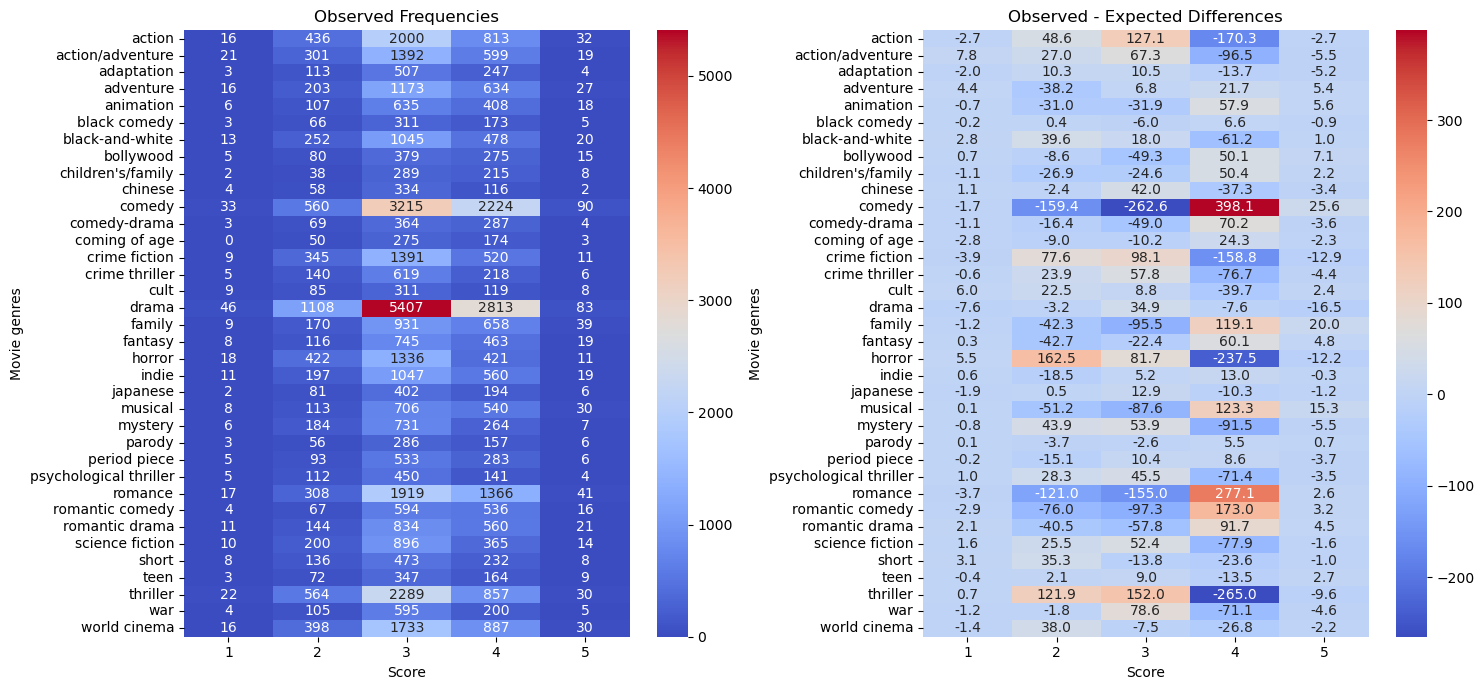

In [73]:
#Chi-square test


genre_score_counts = movies_genres.groupby(['Movie genres', 'Score']).size().unstack(fill_value=0)
chi2, p, dof, expected = chi2_contingency(genre_score_counts)

print("Chi-Square Statistic:", chi2)
print("P-Value:", p)
print("Degrees of Freedom:", dof)

# Create subplots for two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Heatmap of observed frequencies
sns.heatmap(genre_score_counts, annot=True, cmap="coolwarm", fmt="d", ax=axes[0])
axes[0].set_title("Observed Frequencies")

# Heatmap of differences (observed - expected)
sns.heatmap(genre_score_counts - expected, annot=True, cmap="coolwarm", fmt=".1f", ax=axes[1])
axes[1].set_title("Observed - Expected Differences")

plt.tight_layout()
plt.show()

The Chi-square p value is extremely low and smaller than 0.05 (significance threshold), therfore we can reject the null hypothesis.

From the heatmaps, we can see the observed frequencies of movies for each score for each genre and the difference between the expected frequency (what we would expect to see if there were no relationship between movie genres and their ending scores). For example, we can that comedy has a lot more movies with an ending score of 4 (happy ending) than what we would expect if there was no link between genre and ending score.

Although this test proves us that there is a link between the movie genres and the ending of a movie (score), this value is extremely low. It can be explained by a large number of genres, or the fact that some genres have a lot more movies than other. To remedy this, we will have to test a more balanced sample of genres later.

Future steps to explore:

1) Try different statistical tests. To see if there is a significant difference in the average ending score for all genres, we could also perform an ANOVA test (or t-test between 2 genres).
HOWEVER: 
    - ANOVA assumes normally distributed data and similar variances across groups. We will have to verify those assumptions before performing this test.

    - ANOVA only tells us if there is a difference somewhere among the genres, not which specific genres differ.

    If the confitions are not verified, we could also perform the Mann-Whitney U test for example.

2) We can use a different subset of movie genres because since some genres are more represented (e;g; 'drama'), it might influence the results that we have. We can test movie genres that have a sufficient number of movies but not too high either. Also, there are multiple genres for one movie, we might need to take only one into account, but in this case, which one?



### 2. Release date and Influence of historical events

Further analysis will focus on investigating correlations between movies and historical events through various approaches:
1. **Temporal analysis**: Investigate if there is an overall correlation between the happy endings of movies and global conflicts or wars. Account for production delays by shifting the timelines of movies and events by x years to identify where the strongest correlation lies. Possibly 'x' could be determined using a mean production time or finding precise data for the production of eahc movie. This will require to perform temporal analysis by clustering events and movies into defined time periods (e.g., decades).
2. **Geographic Insights**: Explore regional and country-level correlations to identify whether specific regions or nations are disproportionately reflected in movies.
3. **Thematic Connections**: Analyze if movies with themes similar to historical events (e.g., war, diplomacy) reflect the outcomes or nature of those events in their narratives and endings.
4. **Impact of Crisis Severity**: Investigate whether movies produced during or after high-fatality crises tend to have darker or more reflective endings.

### 3. Key personnel (directors)

In [6]:
from src.scripts.rq_3 import get_analysis, get_director_avg_score, get_director_score_variance, get_director_avg_score_vs_avg_revenue, get_director_avg_score_vs_avg_vote_average, t_test_avg_score_on_revenue, t_test_avg_score_on_vote_average, t_test_score_variance_on_revenue, t_test_score_variance_on_vote_average

save_path = "./assets/img/rq3/"

# Get the analysis
director_avg_score, director_score_variance, director_avg_revenue, director_avg_vote_average = get_analysis(MOVIE_DATASET)

In [7]:
# Get the average score of the directors
get_director_avg_score(director_avg_score, save_path=save_path)


In [8]:
# Get the variance of the scores of the directors
get_director_score_variance(director_score_variance, save_path=save_path)

In [10]:
# Get the average score of the directors vs the average revenue
get_director_avg_score_vs_avg_revenue(director_avg_score, director_score_variance, director_avg_revenue, save_path=save_path)

In [11]:
# Get the average score of the directors vs the average vote average
get_director_avg_score_vs_avg_vote_average(director_avg_score, director_score_variance, director_avg_vote_average, save_path=save_path)

In [13]:
# use t test to check if the average score is significantly different between directors with high and low revenue
t_test_avg_score_on_revenue(director_avg_score, director_avg_revenue)

The average score is significantly different between directors with high and low revenue


True

In [14]:
# use t test to check if the average score is significantly different between directors with high and low vote average
t_test_avg_score_on_vote_average(director_avg_score, director_avg_vote_average)

The average score is significantly different between directors with high and low vote average


True

In [15]:
# use t test to check if the score variance is significantly different between directors with high and low revenue
t_test_score_variance_on_revenue(director_score_variance, director_avg_revenue)

The score variance is not significantly different between directors with high and low revenue


False

In [16]:
# use t test to check if the score variance is significantly different between directors with high and low vote average
t_test_score_variance_on_vote_average(director_score_variance, director_avg_vote_average)

The score variance is not significantly different between directors with high and low vote average


False

### 4. Movie's 'success'

Is there a correlation between a movie’s ending and its success (ratings, box office revenue, etc.)?

We will explore whether happy or tragic endings have any impact on a movie's popularity or financial performance.

To do so, we used the the tmdb dataset to augment our dataset and to provide the information of the box office revenue (more complete because in our own dataset we only had this information for ~10% of the movies) and the vote average, which is an average of the audience's rating on the movie. 

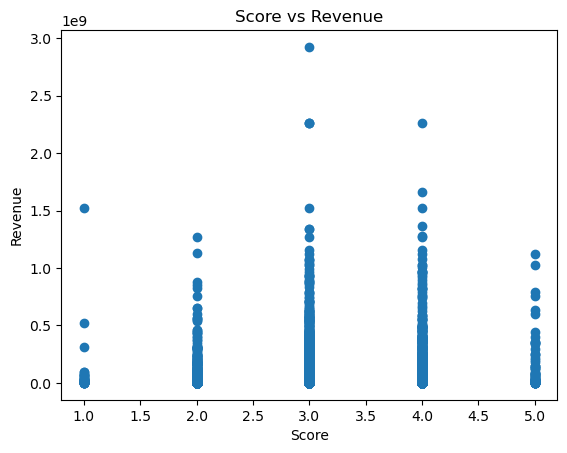

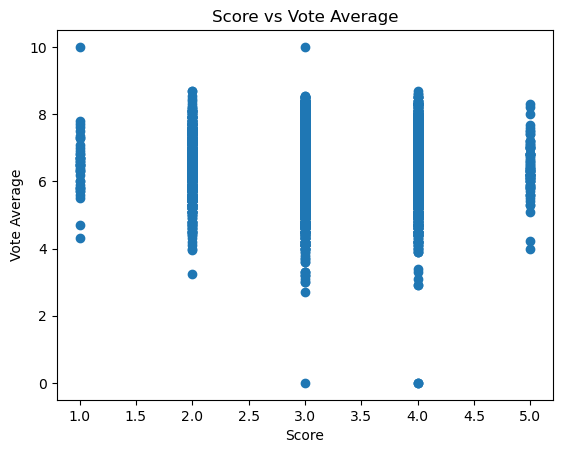

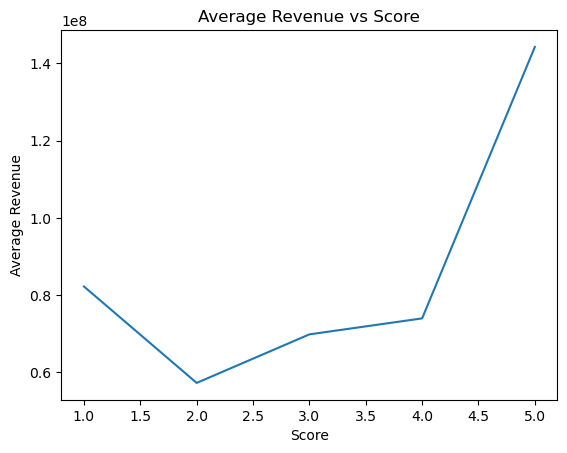

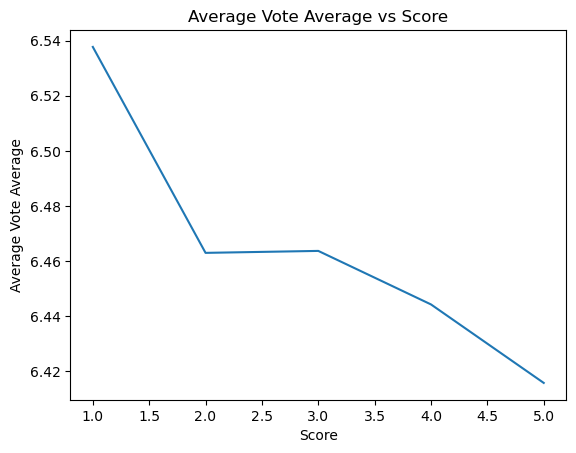

We use a t-test to test if the average revenue is different for movies with score 1 and movies with score 5
t-statistic: -1.3594096978481334
p-value: 0.17660901320022113
The difference is not statistically significant
We use a t-test to test if the average vote average is different for movies with score 1 and movies with score 5
t-statistic: 0.7687718574950436
p-value: 0.4435647150911646
The difference is not statistically significant


In [75]:
# %%
# drop movies without vote average or revenue
movies_filtered = movies.dropna(subset=['vote_average', 'revenue'])

# drop movies with revenue less than 1000
movies_filtered = movies_filtered[movies_filtered['revenue'] > 1000]

# %%
# plot score vs revenue
plt.scatter(movies_filtered['Score'], movies_filtered['revenue'])
plt.xlabel('Score')
plt.ylabel('Revenue')
plt.title('Score vs Revenue')
plt.show()

# %%
# plot score vs vote average
plt.scatter(movies_filtered['Score'], movies_filtered['vote_average'])
plt.xlabel('Score')
plt.ylabel('Vote Average')
plt.title('Score vs Vote Average')
plt.show()


# %%
# calculate the average revenue for each score
average_revenue = movies_filtered.groupby('Score')['revenue'].mean()
average_revenue = average_revenue.sort_index()

# plot average revenue vs score
plt.plot(average_revenue)
plt.xlabel('Score')
plt.ylabel('Average Revenue')
plt.title('Average Revenue vs Score')
plt.show()

# %%
# calculate the average vote average for each score
average_vote_average = movies_filtered.groupby('Score')['vote_average'].mean()
average_vote_average = average_vote_average.sort_index()

# plot average vote average vs score
plt.plot(average_vote_average)
plt.xlabel('Score')
plt.ylabel('Average Vote Average')
plt.title('Average Vote Average vs Score')
plt.show()

# %%
print("We use a t-test to test if the average revenue is different for movies with score 1 and movies with score 5")

movies_score_1_revenue = movies_filtered[movies_filtered['Score'] == 1.0]['revenue'].astype(float)
movies_score_5_revenue = movies_filtered[movies_filtered['Score'] == 5.0]['revenue'].astype(float)

t_stat, p_value = ttest_ind(movies_score_1_revenue, movies_score_5_revenue)

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference is statistically significant')
else:
    print('The difference is not statistically significant')

# %%
print("We use a t-test to test if the average vote average is different for movies with score 1 and movies with score 5")
movies_score_1_vote_average = movies_filtered[movies_filtered['Score'] == 1.0]['vote_average'].astype(float)
movies_score_5_vote_average = movies_filtered[movies_filtered['Score'] == 5.0]['vote_average'].astype(float)

t_stat, p_value = ttest_ind(movies_score_1_vote_average, movies_score_5_vote_average)

print('t-statistic:', t_stat)
print('p-value:', p_value)

if p_value < 0.05:
    print('The difference is statistically significant')
else:
    print('The difference is not statistically significant')

# %%

## 5. Region/Country of production of the movie

### 1. Average Movie Score by Country
A horizontal bar chart showing the **average movie score** for countries with at least **10 films**.

### 2. Evolution of Average Movie Scores Over Time
A line plot displaying the **average movie score** per year, filtered to include only years with at least **50 films**.


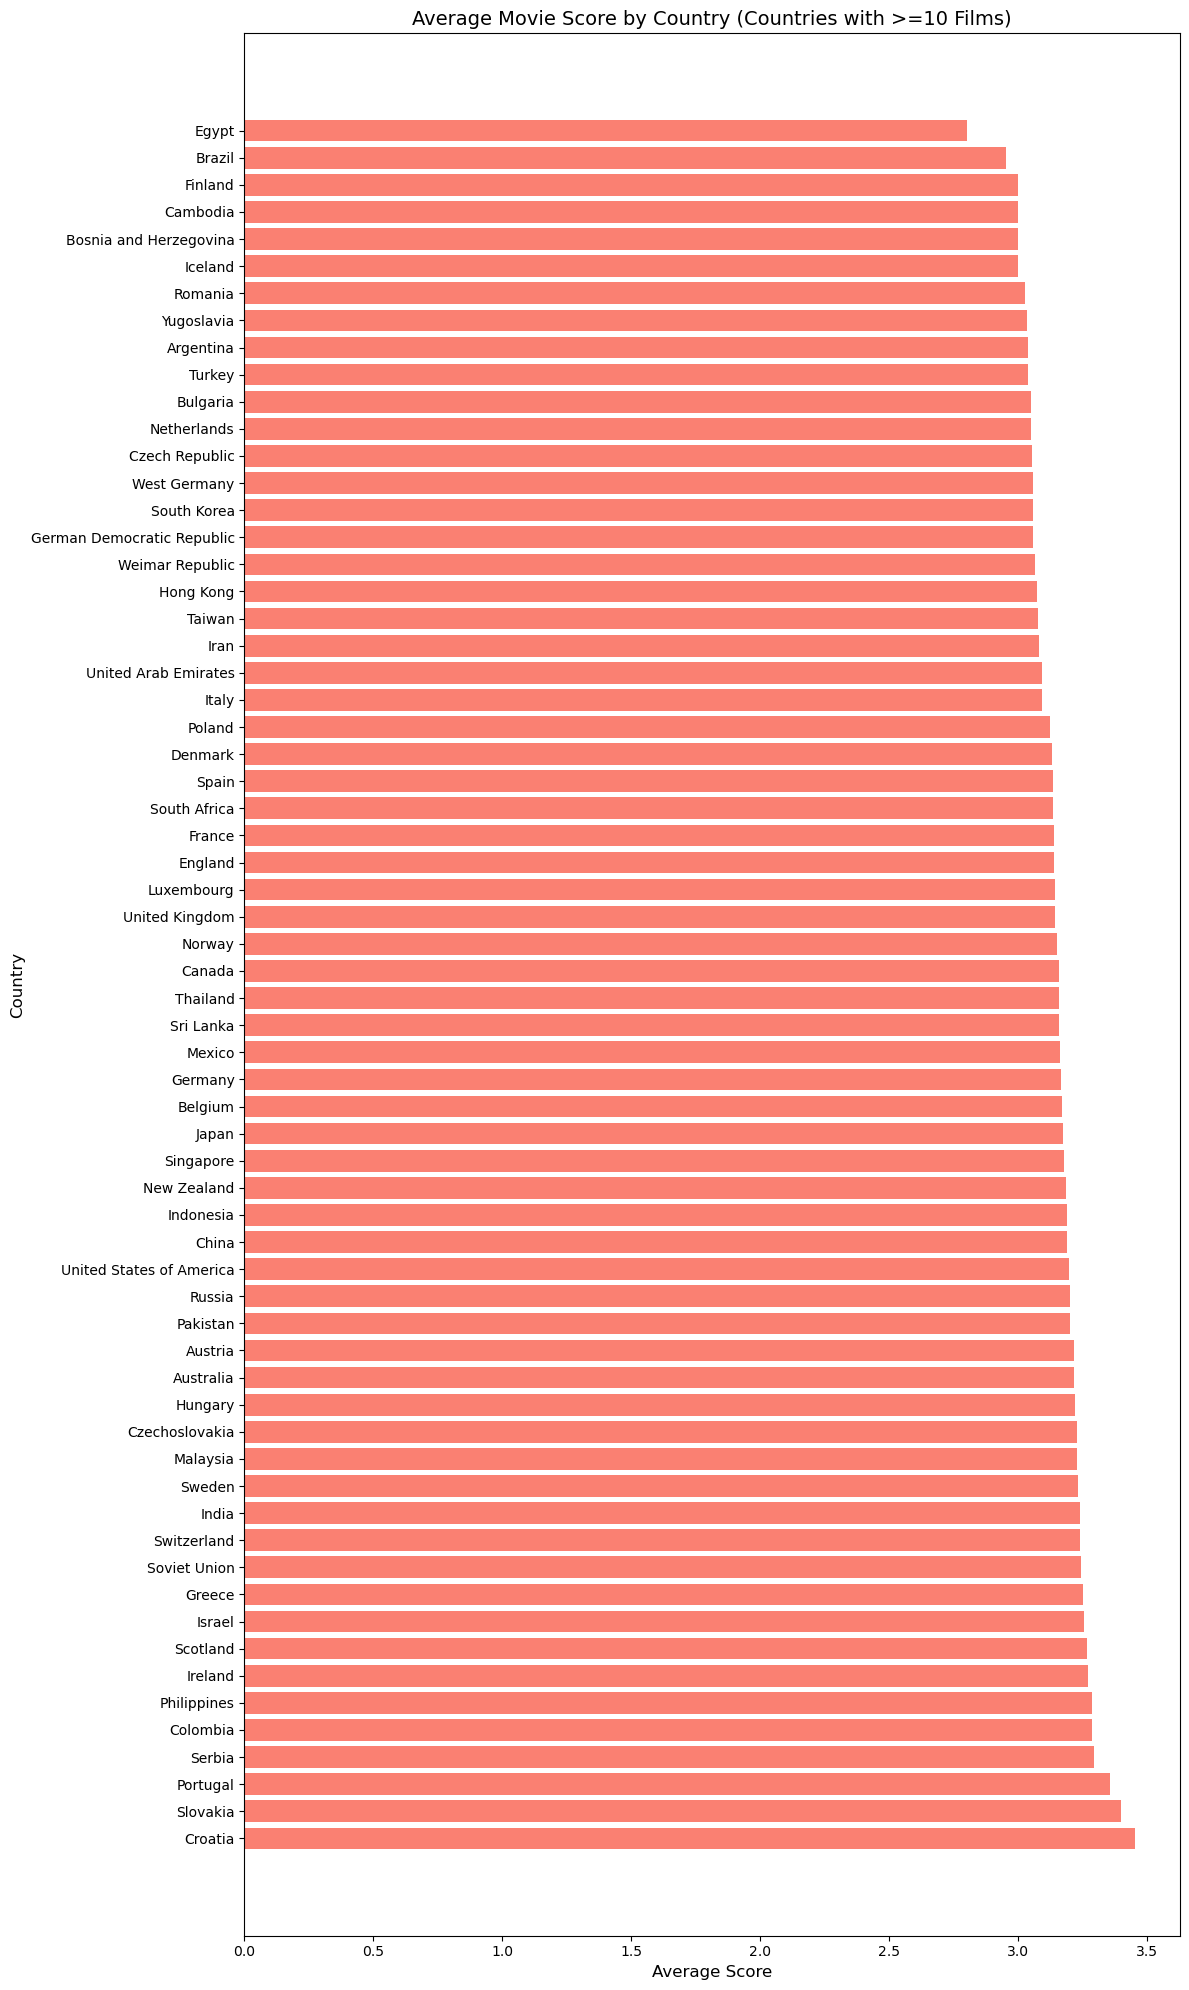

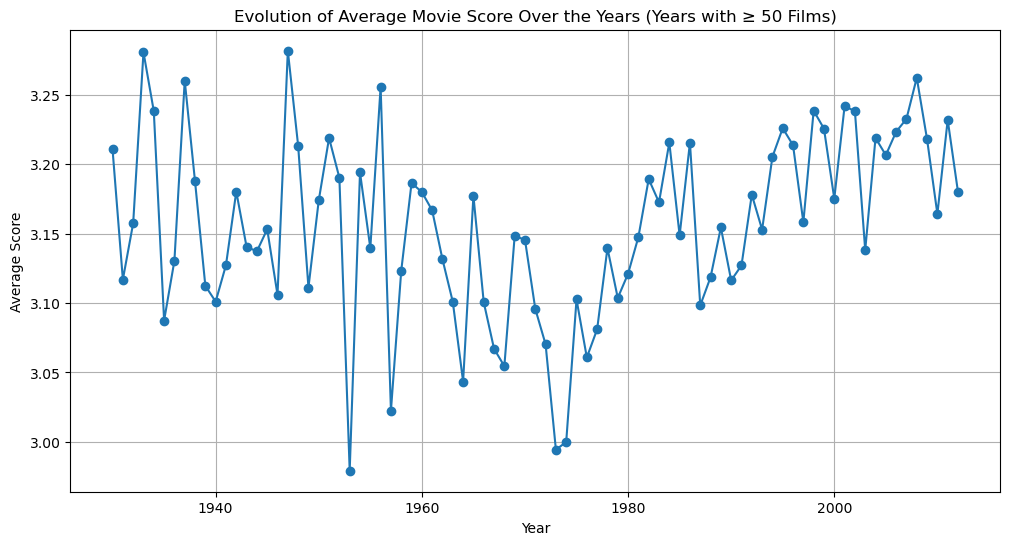

In [76]:
file_path = 'src/data/movies_dataset_final.tsv'
movies_df = pd.read_csv(file_path, sep='\t')

# Split the 'Movie countries' column into individual countries
movies_df = movies_df.assign(Country=movies_df['Movie countries'].str.split(", ")).explode('Country')

# Calculate average score and film count per country
country_stats = movies_df.groupby('Country').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
).sort_values(by='Average_Score', ascending=False)

# Filter countries with at least 10 films
country_stats_10_plus = country_stats[country_stats['Film_Count'] >= 10]

# Plot for countries with at least 10 films
plt.figure(figsize=(12, 20))
plt.barh(country_stats_10_plus.index, country_stats_10_plus['Average_Score'], color='salmon')
plt.ylabel('Country', fontsize=12)
plt.xlabel('Average Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Average Movie Score by Country (Countries with >=10 Films)', fontsize=14)
plt.tight_layout()
plt.show()

score_and_count_by_year = movies_df.groupby('Movie release date').agg(
    Average_Score=('Score', 'mean'),
    Film_Count=('Score', 'size')
)

filtered_data = score_and_count_by_year[score_and_count_by_year['Film_Count'] >= 50]

plt.figure(figsize=(12, 6))
plt.plot(filtered_data.index, filtered_data['Average_Score'], marker='o', linestyle='-')
plt.title('Evolution of Average Movie Score Over the Years (Years with ≥ 50 Films)')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()


## 6. Budget and Production scale

### Do budget and production scale affect the type of ending chosen? Exploring whether high-budget films tend to favor certain endings (e.g., happy endings for wider audience appeal) could reveal if financial considerations impact storytelling choices.


Remove movies with missing values for budget

In [77]:
movies = pd.read_csv(MOVIE_DATASET, sep='\t')
# Count rows where 'budget' is NaN or 0
missing_or_zero_count = movies[(movies['Budget'].isnull()) | (movies['Budget'] == 0)].shape[0]
# Calculate the percentage of these rows
percentage_missing_or_zero = (missing_or_zero_count / len(movies)) * 100
# Remove rows where 'budget' is NaN or 0
movies = movies[(movies['Budget'].notnull()) & (movies['Budget'] > 0)]
# Verify removal
remaining_rows = len(movies)
missing_productions = movies['Production'].isna().sum()


In [78]:
# Function to extract production names
def extract_production_names(production_list):
    # Ensure the input is a list of dictionaries
    if isinstance(production_list, str):
        # If the column contains a string representation of a list (like JSON), convert it to a list
        try:
            production_list = ast.literal_eval(production_list)
        except (ValueError, SyntaxError):
            return []  # Return empty list if there's a parsing error

    # If it's a valid list of dictionaries, extract the 'name'
    if isinstance(production_list, list):
        return [item['name'] for item in production_list if isinstance(item, dict) and 'name' in item]
    return []

# Apply the function to the 'productions' column to extract production names
movies['production_names'] = movies['Production'].apply(extract_production_names)

# Count the number of missing values in the 'production_names' column
missing_production_names = movies['production_names'].isna().sum()


In [79]:
# Extract the first production name for each film
movies['first_production_name'] = movies['production_names'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)


### Statistics

In [80]:
# Calculate the correlation between budget and score
correlation = movies['Budget'].corr(movies['Score'])
print(f"Correlation between budget and score: {correlation:.2f}")

Correlation between budget and score: 0.04


We use an ANOVA (Analysis of Variance) test to determine if the mean scores across the groups of films, defined by their first production, differ significantly. This test is appropriate because we are comparing multiple groups (each corresponding to a different production) on a continuous variable (the film score). ANOVA helps to assess whether the variation in scores is due to differences between the production groups or if it can be attributed to random chance.

In [81]:

# Group by the first production name and calculate the mean score for each production
production_score = movies.groupby('first_production_name')['Score'].mean()

# Perform ANOVA to test if there are significant differences in the scores between production groups
anova_result = stats.f_oneway(*(movies[movies['first_production_name'] == prod]['Score'] for prod in production_score.index))

# Print the result in a cleaner format
if anova_result.pvalue < 0.05:
    print("ANOVA result: There are significant differences in scores between production groups.")
else:
    print("ANOVA result: There are no significant differences in scores between production groups.")

print(f"ANOVA p-value: {anova_result.pvalue:.4f}")


ANOVA result: There are significant differences in scores between production groups.
ANOVA p-value: 0.0076


## 7. Movie's duration

### How do movie endings vary by film length ? This question would explore whether movies of different lengths (e.g., short vs. feature-length) tend to have different types of endings.


### Remove the missing values

In [82]:
movies = pd.read_csv(MOVIE_DATASET, sep='\t')

# Count the number of NaN values in the 'run_time' column
nan_count = movies['Movie runtime'].isna().sum()

# Convert 'run_time' in numeric to avoir errors 
movies['Movie runtime'] = pd.to_numeric(movies['Movie runtime'], errors='coerce')

# Delete rows where 'run_time' is NaN or <= 0
movies_cleaned = movies.dropna(subset=['Movie runtime'])
movies_cleaned = movies_cleaned[movies_cleaned['Movie runtime'] > 0]

### Statistics

We have chosen 40 minutes as the threshold to differentiate between short and long movies. However, this number will be refined later. For now, it serves as a preliminary value to ensure we can perform initial observations.
However, this number will be refined later based on the actual distribution of movie durations in the dataset. A more nuanced categorization could also be considered, such as dividing movies into multiple ranges (e.g., 0-40 minutes, 40-90 minutes, 90-120 minutes, etc.) for more detailed analysis.

In [83]:
# Group by categories
movies_cleaned['duration_category'] = movies_cleaned['Movie runtime'].apply(lambda x: 'Short' if x < 40 else 'Feature-length')
# Calculate descriptive statistics (mean, median, std) for each duration category
group_stats = movies_cleaned.groupby('duration_category')['Score'].agg(['mean', 'median', 'std'])

# Print the result in a formatted way
print("Descriptive Statistics by Duration Category:")
print(group_stats.to_string(index=True, float_format="{:.2f}".format))


Descriptive Statistics by Duration Category:
                   mean  median  std
duration_category                   
Feature-length     3.19    3.00 0.66
Short              3.16    3.00 0.71


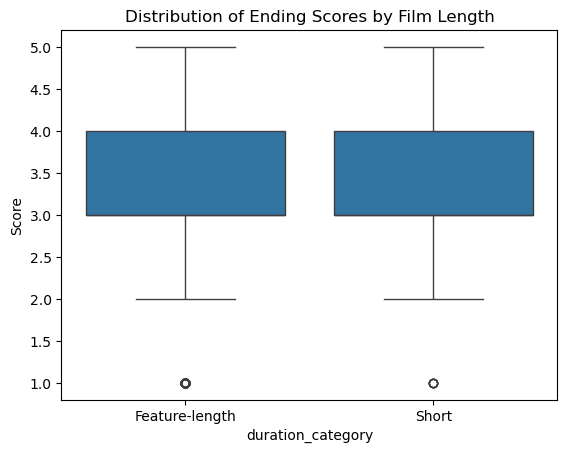

In [84]:
# Boxplot
sns.boxplot(data=movies_cleaned, x='duration_category', y='Score')
plt.title('Distribution of Ending Scores by Film Length')
plt.show()


### Test if the distributions are normal 

In [85]:
# Filter scores for short movies
short_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Short']['Score']

# Filter scores for feature-length movies
feature_scores = movies_cleaned[movies_cleaned['duration_category'] == 'Feature-length']['Score']

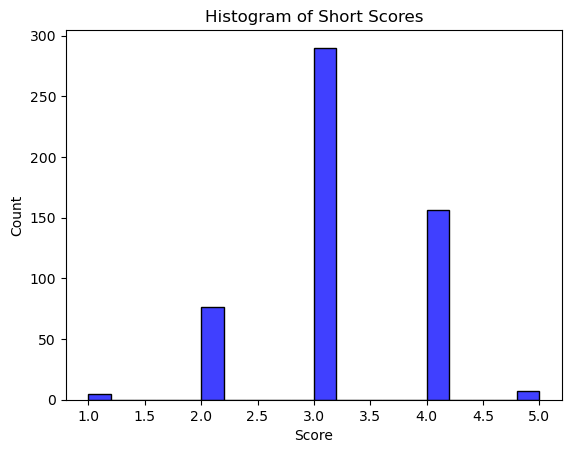

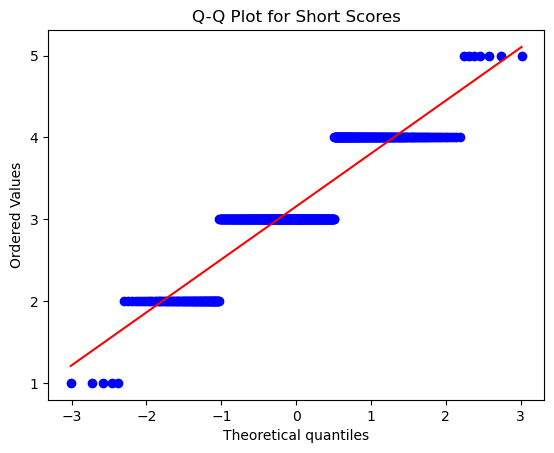

In [86]:
sns.histplot(short_scores, kde=False, bins=20, color='blue')
plt.title("Histogram of Short Scores")
plt.show()

# Q-Q Plot
stats.probplot(short_scores, dist="norm", plot=plt)
plt.title("Q-Q Plot for Short Scores")
plt.show()

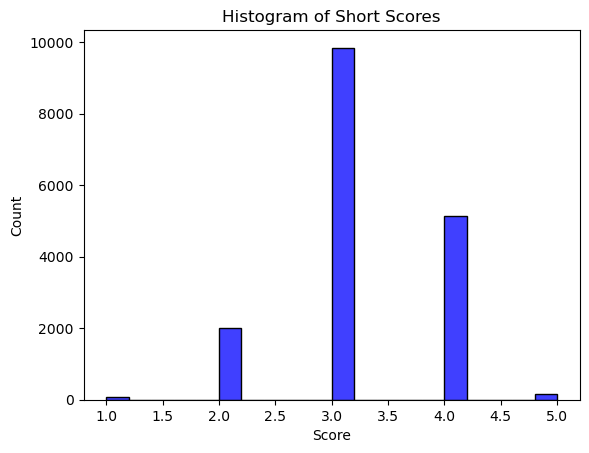

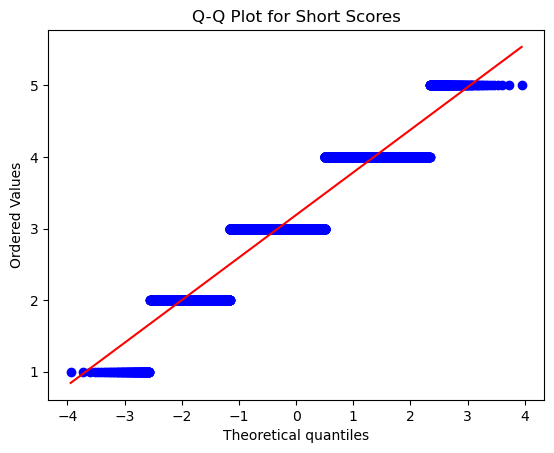

In [87]:
sns.histplot(feature_scores, kde=False, bins=20, color='blue')
plt.title("Histogram of Short Scores")
plt.show()

# Q-Q Plot
stats.probplot(feature_scores, dist="norm", plot=plt)
plt.title("Q-Q Plot for Short Scores")
plt.show()

The Kolmogorov-Smirnov (KS) Test is commonly used for larger datasets because it is a non-parametric test that compares the observed cumulative distribution function (CDF) of a sample with the expected CDF of a normal distribution. Unlike the Shapiro-Wilk test, which is better suited for smaller datasets, the KS test is more reliable and efficient for large samples since it does not assume any specific distribution shape and is less sensitive to the influence of large sample sizes. 

In [88]:

stat, p = kstest(short_scores, 'norm', args=(short_scores.mean(), short_scores.std()))
print(f"KS Test: statistic={stat:.4f}, p-value={p}")

if p > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")
from scipy.stats import kstest

stat, p = kstest(short_scores, 'norm', args=(feature_scores.mean(), short_scores.std()))
print(f"KS Test: statistic={stat:.4f}, p-value={p}")

if p > 0.05:
    print("The data follows a normal distribution (fail to reject H0).")
else:
    print("The data does not follow a normal distribution (reject H0).")


KS Test: statistic=0.2827, p-value=2.9358291729951156e-38
The data does not follow a normal distribution (reject H0).
KS Test: statistic=0.3007, p-value=2.5864664728167323e-43
The data does not follow a normal distribution (reject H0).


The Mann-Whitney U test is used when comparing two independent groups, especially when the data does not follow a normal distribution or when the assumptions of the t-test (e.g., normality and homogeneity of variance) are violated. It is a non-parametric test that evaluates whether the distributions of the two groups are different by comparing the ranks of the values.

In [89]:
# Test Mann-Whitney U
u_stat, p_value_u = mannwhitneyu(short_scores, feature_scores)

from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test to compare 'short_scores' and 'feature_scores'
u_stat, p_value_u = mannwhitneyu(short_scores, feature_scores)

# Print the results of the test
print(f"Mann-Whitney U Test Results:\nU-statistic: {u_stat:.4f}\np-value: {p_value_u:.4f}")

# Interpretation based on p-value
if p_value_u < 0.05:
    print("The distributions of short and feature-length films' scores are significantly different (reject H0).")
else:
    print("There is no significant difference between the distributions of short and feature-length films' scores (fail to reject H0).")


Mann-Whitney U Test Results:
U-statistic: 4507485.0000
p-value: 0.3306
There is no significant difference between the distributions of short and feature-length films' scores (fail to reject H0).


## 8. Collection of movies

### Do sequels or franchise movies follow different patterns in their endings compared to standalone films? 

Investigating whether franchise movies are more likely to have open-ended or happy endings to encourage future installments could reveal a unique trend in storytelling within cinematic universes.

Since films belonging to a collection have a collection number, while standalone films are labeled as 'NaN,' we created a binary column where '1' marks films in a collection and '0' marks standalone films.

In [90]:
movies = pd.read_csv(MOVIE_DATASET, sep='\t')
# create a binary column indicating if the movie belongs to a collection
movies['in_collection'] = movies['collection'].notna().astype(int)

#### Statistics

In [91]:
# calculate mean between groups
mean_scores = movies.groupby('in_collection')['Score'].mean()

#printing
print(f"\n{'-'*40}")
print("Average Scores for Standalone vs. Collection Movies")
print(f"{'-'*40}")
print(f"{'Standalone Movies (0)':<25}: {mean_scores[0]}")
print(f"{'Collection Movies (1)':<25}: {mean_scores[1]}")
print(f"{'-'*40}")


----------------------------------------
Average Scores for Standalone vs. Collection Movies
----------------------------------------
Standalone Movies (0)    : 3.1883693853790063
Collection Movies (1)    : 3.172043010752688
----------------------------------------



Quantiles for Standalone and Collection Movies
Quantile   Standalone (0)       Collection (1)
----------------------------------------
25th Percentile: 3.0                  3.0
50th Percentile: 3.0                  3.0
75th Percentile: 4.0                  4.0


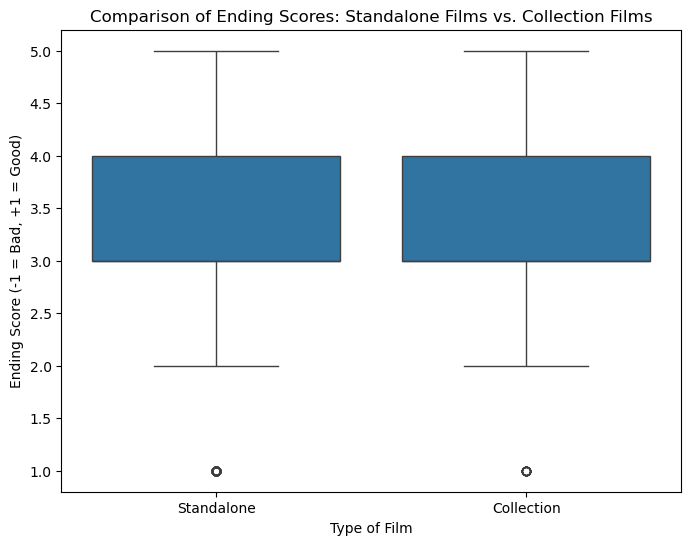

In [92]:
# Quantile for each group 
quantiles = movies.groupby('in_collection')['Score'].quantile([0.25, 0.5, 0.75]).unstack()
quantiles = quantiles.round(2)

# printing
print("\n" + "="*40)
print("Quantiles for Standalone and Collection Movies")
print("="*40)
print(f"{'Quantile':<10} {'Standalone (0)':<20} {'Collection (1)'}")
print("-"*40)

for quantile in [0.25, 0.5, 0.75]:
    print(f"{quantile*100:.0f}th Percentile: {quantiles[quantile][0]:<20} {quantiles[quantile][1]}")

print("="*40)

# Boxplot of score according to the collection belonging 
plt.figure(figsize=(8, 6))
sns.boxplot(data=movies, x='in_collection', y='Score')
plt.xticks([0, 1], ['Standalone', 'Collection'])
plt.xlabel('Type of Film')
plt.ylabel('Ending Score (-1 = Bad, +1 = Good)')
plt.title('Comparison of Ending Scores: Standalone Films vs. Collection Films')
plt.show()


#### The goal of this code is to perform a statistical test (t-test) to compare the ending scores between two groups of movies: those that belong to a collection (franchise or series) and those that are standalone films.

 The t-test helps us assess whether there is a statistically significant difference in the mean ending scores between franchise (collection) films and standalone films. If the p-value is less than 0.05, it would indicate that the difference in scores is statistically significant, implying that the type of film (franchise vs. standalone) could influence the ending scores.
 
We use an independent t-test because it is designed to compare the means of two independent groups (franchise vs. standalone films) to determine if there is a statistically significant difference in their ending scores, which is more appropriate than tests like paired t-tests or ANOVA for this type of data structure.

In [93]:
# Filter the movies DataFrame to get scores for movies in a collection (franchise or series)
scores_collection = movies[movies['in_collection'] == 1]['Score']

# Filter the movies DataFrame to get scores for standalone movies (not in a collection)
scores_standalone = movies[movies['in_collection'] == 0]['Score']

# Perform an independent t-test to compare the mean scores of the two groups
# The 'nan_policy="omit"' ensures that any NaN values are excluded from the test
t_stat, p_value = ttest_ind(scores_collection, scores_standalone, nan_policy='omit')

# Print the t-statistic and p-value
# The t-statistic tells us the magnitude of the difference between the groups
# The p-value helps us determine if the difference is statistically significant
print(f"\nT-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

# Check if the p-value is less than 0.05 to determine if the difference is statistically significant
if p_value < 0.05:
    print("\nThe difference between franchise and standalone films' ending scores is statistically significant.")
else:
    print("\nThere is no statistically significant difference between franchise and standalone films' ending scores.")



T-statistic: -1.23, p-value: 0.2196

There is no statistically significant difference between franchise and standalone films' ending scores.


#### Counting and visualizing the distribution of standalone vs. collection films


Distribution of Movies by Type:
Standalone Films: 16319
Collection Films: 2976


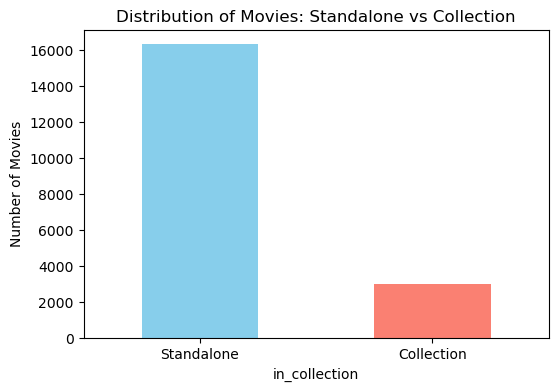

In [94]:
# Count the number of films in each group: 'Collection' and 'Standalone'
group_counts = movies['in_collection'].value_counts()

# Print the group counts with a clearer message
print("\nDistribution of Movies by Type:")
print("="*40)
print(f"Standalone Films: {group_counts.get(0, 0)}")
print(f"Collection Films: {group_counts.get(1, 0)}")
print("="*40)

# Visualization to display the balance between the two groups
import matplotlib.pyplot as plt

# Create a bar plot to show the distribution of standalone vs. collection films
plt.figure(figsize=(6, 4))
group_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Customize the plot for better readability
plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies: Standalone vs Collection')

# Display the plot
plt.show()


We use undersampling here because it helps to create a balanced dataset, where both groups (standalone and collection films) have an equal number of films. This is important for ensuring that the analysis isn't biased toward the more frequent group. We could have also used oversampling, but undersampling is chosen here to avoid artificially inflating the number of data points in the smaller group, which could lead to overfitting


New distribution of movies after undersampling:
in_collection
1    2976
0    2976
Name: count, dtype: int64


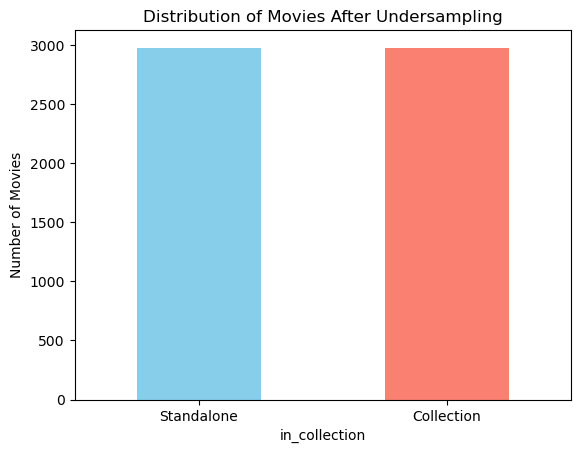

In [95]:
# Undersampling: Keep an equal number of standalone and collection films

# Filter movies that belong to a collection (franchise or series)
collection_movies = movies[movies['in_collection'] == 1]

# Filter movies that are standalone (not in any collection)
standalone_movies = movies[movies['in_collection'] == 0]

# Undersample the standalone films to match the number of collection films
standalone_movies_resampled = standalone_movies.sample(n=group_counts[1], random_state=42)

# Combine the undersampled standalone films with the collection films
movies_resampled = pd.concat([collection_movies, standalone_movies_resampled])

# Check the new distribution of the dataset after undersampling
print("\nNew distribution of movies after undersampling:")
print("="*40)
print(movies_resampled['in_collection'].value_counts())
print("="*40)

# Visualization of the distribution after undersampling
movies_resampled['in_collection'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
plt.ylabel('Number of Movies')
plt.title('Distribution of Movies After Undersampling')
plt.show()



Average Scores for Standalone vs Collection Movies (After Undersampling):
Standalone Films: 3.1979166666666665
Collection Films: 3.172043010752688


C:\Users\nicol\AppData\Local\Temp\ipykernel_29544\621725702.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='in_collection', y='Score', data=movies_resampled, palette='coolwarm')


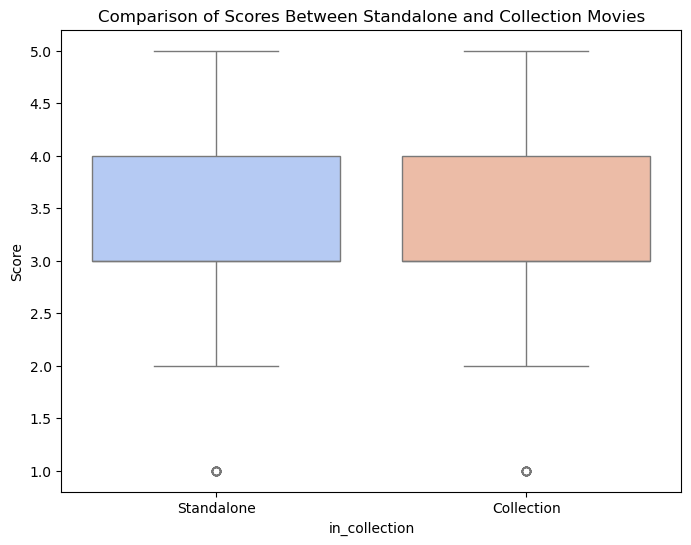

In [96]:
# Comparison of the average scores between collection films and standalone films after undersampling

# Calculate the mean score for each group (Standalone and Collection films)
mean_scores_resampled = movies_resampled.groupby('in_collection')['Score'].mean()

# Print the mean scores with a more informative message
print("\nAverage Scores for Standalone vs Collection Movies (After Undersampling):")
print("="*60)
print(f"Standalone Films: {mean_scores_resampled.get(0, 'N/A')}")
print(f"Collection Films: {mean_scores_resampled.get(1, 'N/A')}")
print("="*60)

# Visualizing the distribution of scores between the two groups
plt.figure(figsize=(8, 6))

# Create a boxplot to compare the score distributions
sns.boxplot(x='in_collection', y='Score', data=movies_resampled, palette='coolwarm')

# Customize the plot for better readability
plt.xticks([0, 1], ['Standalone', 'Collection'], rotation=0)
plt.ylabel('Score')
plt.title('Comparison of Scores Between Standalone and Collection Movies')

# Display the plot
plt.show()


In [97]:

# Separate the scores of collection films and standalone films after resampling
scores_collection_resampled = movies_resampled[movies_resampled['in_collection'] == 1]['Score']
scores_standalone_resampled = movies_resampled[movies_resampled['in_collection'] == 0]['Score']

# Perform a t-test to compare the scores between the two groups (collection vs. standalone)
t_stat_resampled, p_value_resampled = ttest_ind(scores_collection_resampled, scores_standalone_resampled, nan_policy='omit')

# Print the results with more informative formatting
print("\nT-test Results Comparing Scores Between Standalone and Collection Movies (After Undersampling):")
print("="*70)
print(f"T-statistic (Resampled Data): {t_stat_resampled:.4f}")
print(f"P-value (Resampled Data): {p_value_resampled:.4f}")
print("="*70)

# Interpretation of the results
if p_value_resampled < 0.05:
    print("The difference in scores between Standalone and Collection films is statistically significant.")
else:
    print("The difference in scores between Standalone and Collection films is not statistically significant.")



T-test Results Comparing Scores Between Standalone and Collection Movies (After Undersampling):
T-statistic (Resampled Data): -1.4960
P-value (Resampled Data): 0.1347
The difference in scores between Standalone and Collection films is not statistically significant.


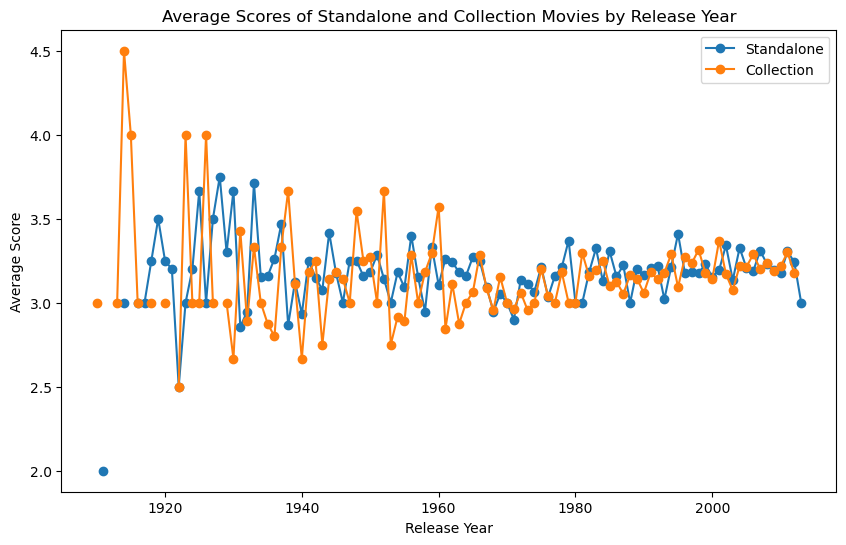

In [98]:
# Calculate the average scores by release year for both standalone and collection films
scores_by_year = movies_resampled.groupby(['Movie release date', 'in_collection'])['Score'].mean().unstack()

# Visualize the average scores over the years for both groups
scores_by_year.plot(kind='line', figsize=(10, 6), marker='o')

# Customize the plot for better readability
plt.xlabel('Release Year')
plt.ylabel('Average Score')
plt.title('Average Scores of Standalone and Collection Movies by Release Year')
plt.legend(['Standalone', 'Collection'])

# Display the plot
plt.show()